# Reparametrization Trick in Variational Autoencoders (VAEs)

## Introduction

The reparametrization trick is a technique used in Variational Autoencoders (VAEs) to enable backpropagation through stochastic nodes. VAEs are a type of generative model that learn to encode and decode data in a probabilistic manner. One of the challenges in training VAEs is the presence of a stochastic (random) layer that samples from a distribution. Traditional backpropagation algorithms cannot handle stochastic nodes directly.

## The Problem

In VAEs, the encoder network produces a mean and a variance for each latent variable. During the forward pass, we sample from a Gaussian distribution with these parameters to obtain the latent variables. This sampling operation is non-deterministic, making it difficult to backpropagate errors through it.

## The Solution: Reparametrization Trick

The reparametrization trick provides a way to 'reparameterize' the sampling operation so that it becomes differentiable. Instead of sampling from a distribution parameterized by the mean and variance, we sample from a standard normal distribution and then transform it using the mean and variance. This allows us to backpropagate errors through the stochastic layer, enabling the training of VAEs.


## Importing Libraries

First, let's import the necessary libraries 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Simple Example of Reparametrization Trick

To understand the reparametrization trick, let's consider a simple example where we have a Gaussian distribution with a mean $\mu $ and a standard deviation $\sigma$

### Without Reparametrization

Normally, we would sample from this distribution as follows:

$$
z = \text{sample from } N(\mu, \sigma^2)
$$

### With Reparametrization

Using the reparametrization trick, we can rewrite this as:

$$
z = \mu + \sigma \times \text{sample from } N(0, 1)
$$

By doing this, we make the operation differentiable with respect to $ \mu $ and $\sigma$, allowing for backpropagation.


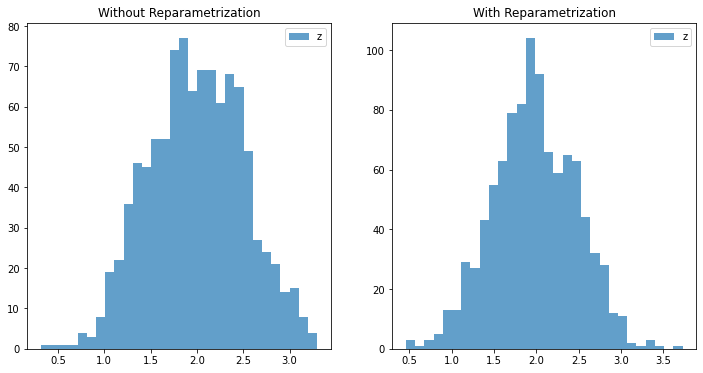

In [8]:
# Define mean and standard deviation
mu = 2.0
sigma = 0.5

# Number of samples
n_samples = 1000

# Without reparametrization
z_without_reparam = np.random.normal(mu, sigma, n_samples)

# With reparametrization
epsilon = np.random.normal(0, 1, n_samples)
z_with_reparam = mu + sigma * epsilon

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Without Reparametrization')
plt.hist(z_without_reparam, bins=30, alpha=0.7, label='z')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('With Reparametrization')
plt.hist(z_with_reparam, bins=30, alpha=0.7, label='z')
plt.legend()
plt.show()

# Demonstration

We will be using a simple example, our target is to optimize the mean to be as close to 2.0 as possible.

In [9]:
target_mean = 2.0

### Without reparametrization trick
Firstly, let's see what happens when we do not use the trick:

Step 0, Loss: 4.1522674560546875, Mu: 0.0, Sigma: 1.0
No change for 11 steps, stopping training at step 11


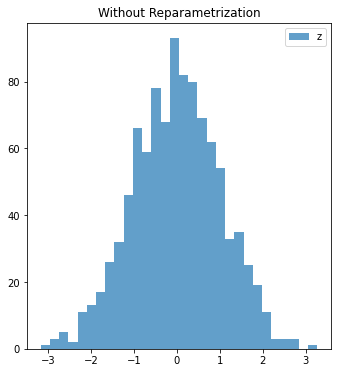

In [10]:
# Define variables (mean and log variance)
mu = torch.tensor(0.0, requires_grad=True)
log_var = torch.tensor(0.0, requires_grad=True)

# Set optimizer
optimizer = torch.optim.Adam([mu, log_var], lr=0.01)

# Variables to show no change
no_change = 0
mu_old = 0
log_var_old = 0

for step in range(1000):
    optimizer.zero_grad()

    # Sample without reparametrization trick
    sigma = torch.exp(log_var * 0.5)
    samples = torch.normal(mean=mu.expand(1000), std=sigma.expand(1000))

    # Objective function
    loss = ((samples.mean() - target_mean)**2)
    
    loss.backward()
    
    
    if step > 0 and (mu_old == mu.grad and log_var_old == log_var.grad):
        no_change += 1
    else:
        mu_old = mu.grad
        log_var_old = log_var.grad

    if no_change > 10:
        print(f"No change for {no_change} steps, stopping training at step {step}")
        break

    optimizer.step()
    
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item()}, Mu: {mu.item()}, Sigma: {torch.exp(log_var * 0.5).item()}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Without Reparametrization')
plt.hist(samples.detach().numpy(), bins=30, alpha=0.7, label='z')
plt.legend()

As you can see we encountered an early stop due to no change in the first steps, it's impossible to optimize the mean without any change in the gradient. Short explanation: we cannot take the derivative of a random variable.

### With reparametrization trick
Now let's see how it works with the reparametrization trick:

Step 0, Loss: 4.180858135223389, Mu: 0.009999999776482582, Sigma: 0.9950124621391296
Step 100, Loss: 1.279354214668274, Mu: 0.9099351763725281, Sigma: 1.00774085521698
Step 200, Loss: 0.22119314968585968, Mu: 1.5124846696853638, Sigma: 0.9357064962387085
Step 300, Loss: 0.026294641196727753, Mu: 1.8266702890396118, Sigma: 0.9049364328384399
Step 400, Loss: 0.002147096209228039, Mu: 1.9553629159927368, Sigma: 0.8821663856506348
Step 500, Loss: 0.0006314886268228292, Mu: 1.9918535947799683, Sigma: 0.8645819425582886
Step 600, Loss: 1.0246450983686373e-05, Mu: 1.9965250492095947, Sigma: 0.8498042821884155
Step 700, Loss: 0.0004961371305398643, Mu: 1.9948914051055908, Sigma: 0.8338474631309509
Step 800, Loss: 0.0005850613815709949, Mu: 2.0019803047180176, Sigma: 0.8172615170478821
Step 900, Loss: 0.00024853370268829167, Mu: 1.9980132579803467, Sigma: 0.8021270036697388


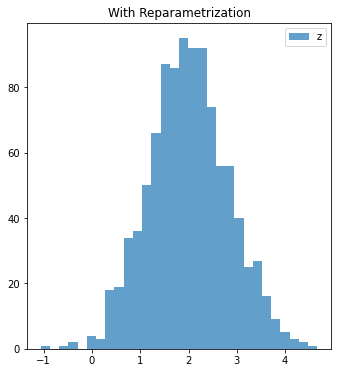

In [11]:
import torch

# Define variables (mean and log variance)
mu = torch.tensor(0.0, requires_grad=True)
log_var = torch.tensor(0.0, requires_grad=True)

# Set optimizer
optimizer = torch.optim.Adam([mu, log_var], lr=0.01)

# Variables to show no change
no_change = 0
mu_old = 0
log_var_old = 0

for step in range(1000):
    optimizer.zero_grad()

    # Reparametrization trick
    epsilon = torch.randn(1000)
    sigma = torch.exp(log_var * 0.5)
    samples = mu + epsilon * sigma

    # Objective function
    loss = ((samples.mean() - target_mean)**2)
    
    loss.backward()
    
    if step > 0 and (mu_old == mu.grad and log_var_old == log_var.grad):
        no_change += 1
    else:
        mu_old = mu.grad
        log_var_old = log_var.grad

    if no_change > 10:
        print(f"No change for {no_change} steps, stopping training at step {step}")
        break
    
    optimizer.step()
    
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item()}, Mu: {mu.item()}, Sigma: {torch.exp(log_var * 0.5).item()}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('With Reparametrization')
plt.hist(samples.detach().numpy(), bins=30, alpha=0.7, label='z')
plt.legend()


Here, the gradients exist and the optimization proceeds as expected, because we employed the reparametrization trick.